In [3]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
BATCH_SIZE = 2

IMG_SIZE = 512

MASK_SIZE = 512

NUM_CLASSES = 5

NUM_TRAIN_IMAGES = 7470

NUM_VAL_IMAGES = 1602

NUM_TEST_IMAGES = 1602

VERSION = '5.9'

# Load data

In [5]:
abs_path = %pwd

In [6]:
slash_idx = [idx for idx,ch in enumerate(abs_path) if ch=='/']

abs_path = abs_path[:slash_idx[-2]]

In [7]:
DATA_DIR = abs_path + '/data/processed'

In [8]:
TRAIN_PATH = DATA_DIR + '/train'
VAL_PATH = DATA_DIR + '/val'
TEST_PATH = DATA_DIR + '/test'

Parameters of image changed by dataset authors during augmentation:

1. hue  X
2. saturation  X
3. grayscale 
4. contrast  X
5. brightness  X
6. sharpness X
7. adding noise
8. doing flipping  X
9. rotation  X
10. cropping  X
11. padding

In [9]:
@tf.function
def augmentation(input_image, input_mask):
    
    # random crop and resize
    if tf.random.uniform(()) > 0.5:
        
        crop_size = np.random.randint(420, 490, dtype=int)
        
        input_image = tf.image.random_crop(input_image, size=(crop_size, crop_size, 3))
        input_image = tf.image.resize(input_image, [IMG_SIZE, IMG_SIZE])
        
        input_mask = tf.image.resize(input_mask, [IMG_SIZE, IMG_SIZE])
        input_mask = tf.image.random_crop(input_mask, size=(crop_size, crop_size, 1))
        input_mask = tf.image.resize(input_mask, [MASK_SIZE, MASK_SIZE])
        
    # random hue
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_hue(input_image, 0.2)
    
    # random saturation
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_saturation(input_image, 5, 10)
    
    # sharpness (image quality decrease)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_jpeg_quality(input_image, 75, 95)
        input_image = tf.reshape(input_image, (IMG_SIZE, IMG_SIZE,3))
        
    # random brightness adjustment illumination
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_brightness(input_image, 0.3)
    
    # random contrast adjustment
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.random_contrast(input_image, 0.2, 0.5)
    
    # random horizontal flip
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    # random vertical flip
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_up_down(input_image)
        input_mask = tf.image.flip_up_down(input_mask)

#     # rotation in 30° steps
#     if tf.random.uniform(()) > 0.5:
#         rot_factor = tf.cast(tf.random.uniform(shape=[], maxval=12, dtype=tf.int32), tf.float32)
#         angle = np.pi/12*rot_factor
#         input_image = tfa.image.rotate(input_image, angle)
#         input_mask = tfa.image.rotate(input_mask, angle)
    
    return input_image, input_mask

In [10]:
train_images = sorted(glob(os.path.join(TRAIN_PATH, "images/img/*")))
train_masks = sorted(glob(os.path.join(TRAIN_PATH, "masks/img/*")))
val_images = sorted(glob(os.path.join(VAL_PATH, "images/img/*")))
val_masks = sorted(glob(os.path.join(VAL_PATH, "masks/img/*")))


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=3)
        image = image[..., 0]
        image = tf.reshape(image, (MASK_SIZE, MASK_SIZE, 1))
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[MASK_SIZE, MASK_SIZE])
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
        image = image / 255.
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def load_augmented_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    image, mask = augmentation(image, mask)
    return image, mask


def data_generator(image_list, mask_list, augmentation=False, factor=1):
    
    """
    Returns augmented or not augmented dataset with the same amount of elements.
    
    Args:
    image_list: list of paths to each image
    mask_list: list of paths to corresponding masks of images (sorted)
    augmentation: "True" for getting augmeneted images and masks
    """
    
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    
    if augmentation:
        dataset = dataset.map(load_augmented_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    else:
        dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
        
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    
    if factor > 1 and augmentation:
        for _ in range(factor-1):
            dataset_to_concat = dataset.map(load_augmented_data, num_parallel_calls=tf.data.AUTOTUNE)
            dataset = dataset.concatenate(dataset_to_concat)

    return dataset

In [11]:
train_dataset = data_generator(train_images, train_masks, augmentation=False)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Number of images in Train Dataset:", BATCH_SIZE * len(train_dataset))
print("Val Dataset:", val_dataset)
print("Number of images in Val Dataset:", BATCH_SIZE * len(val_dataset))


Train Dataset: <BatchDataset shapes: ((2, 512, 512, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>
Number of images in Train Dataset: 7470
Val Dataset: <BatchDataset shapes: ((2, 512, 512, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>
Number of images in Val Dataset: 1602


# Class balance 

In [12]:
# class_count = {
#     0: 0.0,
#     1: 0.0,
#     2: 0.0,
#     3: 0.0,
#     4: 0.0
# }

# for mask_path in train_masks:

#     mask = read_image(mask_path, mask=True)
    
#     class_arr = mask[..., 0]

#     one_mask_count = np.unique(class_arr, return_counts=True)

#     for i in range(len(one_mask_count[0])):
#         class_count[one_mask_count[0][i]] += one_mask_count[1][i]

# class_count

,class_number,pixel_count
background,0,1.134440e+09
buildings,1,1.676724e+07
woodland,2,6.487148e+08
water,3,1.265083e+08
roads,4,3.178538e+07


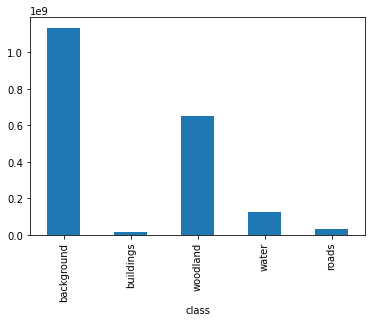

In [13]:
# create dict with already calculated values to bypass renewed calculating

class_count = {
     0: 1134439928.0, 
     1: 16767238.0, 
     2: 648714832.0, 
     3: 126508305.0, 
     4: 31785377.0
}

class_names = ['background', 'buildings', 'woodland', 'water', 'roads']

df = pd.DataFrame(data=class_count.items(), 
                  index=class_names, 
                  columns=['class_number', 'pixel_count'])

df.loc[:, 'pixel_count'].plot.bar()
plt.xlabel('class')

df

In [14]:
def get_class_weight(dictionary):
    
    weights_dict = {}
    
    n_samples = sum(dictionary.values())
    
    for key in dictionary:
        weights_dict[key] = round(n_samples / (NUM_CLASSES * dictionary[key]), 4)
        
    return weights_dict

In [15]:
# def get_class_weight(dictionary):
    
#     id_max_val = max(dictionary, key=dictionary.get)
#     max_val = dictionary[id_max_val]
    
#     for key in dictionary:
#         dictionary[key] = int(max_val / dictionary[key])
        
#     return dictionary

In [16]:
class_weight = get_class_weight(class_count)
class_weight

{0: 0.3452, 1: 23.3576, 2: 0.6037, 3: 3.0958, 4: 12.3215}

# DeepLabv3+

https://keras.io/examples/vision/deeplabv3_plus/

## Create model architecture

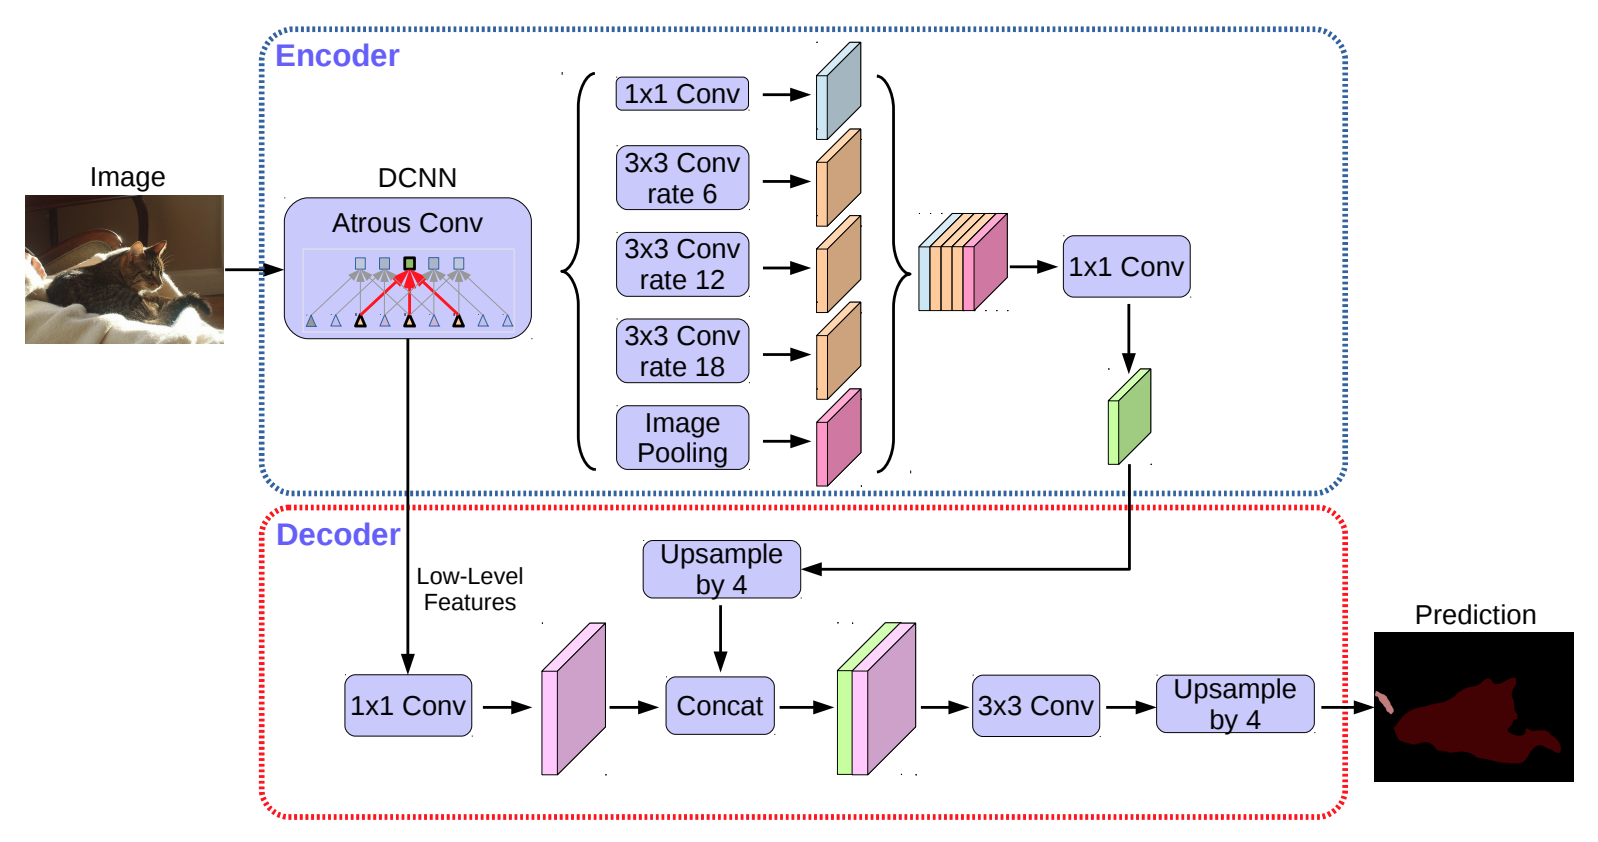

In [17]:
# https://github.com/bonlime/keras-deeplab-v3-plus

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

from tensorflow.python.keras.models import Model
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Reshape
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Concatenate
from tensorflow.python.keras.layers import Add
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import DepthwiseConv2D
from tensorflow.python.keras.layers import ZeroPadding2D
from tensorflow.python.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras.utils.layer_utils import get_source_inputs
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input

WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"


def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1].value  # inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(tf.nn.relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(tf.nn.relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(512, 512, 3), classes=21, backbone='mobilenetv2',
              OS=16, alpha=1., activation=None):
    """ Instantiates the Deeplabv3+ architecture
    Optionally loads weights pre-trained
    on PASCAL VOC or Cityscapes. This model is available for TensorFlow only.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc),
            'cityscapes' (pre-trained on cityscape) or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images. None is allowed as shape/width
        classes: number of desired classes. PASCAL VOC has 21 classes, Cityscapes has 19 classes.
            If number of classes not aligned with the weights used, last layer is initialized randomly
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        activation: optional activation to add to the top of the network.
            One of 'softmax', 'sigmoid' or None
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone. Pretrained is only available for alpha=1.
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """

    if not (weights in {'pascal_voc', 'cityscapes', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `pascal_voc`, or `cityscapes` '
                         '(pre-trained on PASCAL VOC)')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = input_tensor

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same', use_bias=False,
                   name='Conv' if input_shape[2] == 3 else 'Conv_')(img_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        x = Activation(tf.nn.relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    b4_shape = tf.keras.backend.int_shape(b4)
    # from (b_size, channels)->(b_size, 1, 1, channels)
    b4 = Reshape((1, 1, b4_shape[1]))(b4)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation(tf.nn.relu)(b4)
    # upsample. have to use compat because of the option align_corners
    size_before = tf.keras.backend.int_shape(x)
    b4 = tf.keras.layers.experimental.preprocessing.Resizing(
            *size_before[1:3], interpolation="bilinear"
        )(b4)
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation(tf.nn.relu, name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation(tf.nn.relu)(x)
    x = Dropout(0.1)(x)
    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block
        skip_size = tf.keras.backend.int_shape(skip1)
        x = tf.keras.layers.experimental.preprocessing.Resizing(
                *skip_size[1:3], interpolation="bilinear"
            )(x)
        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation(tf.nn.relu)(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if (weights == 'pascal_voc' and classes == 21) or (weights == 'cityscapes' and classes == 19):
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = tf.keras.layers.experimental.preprocessing.Resizing(
            *size_before3[1:3], interpolation="bilinear"
        )(x)
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    if activation in {'softmax', 'sigmoid'}:
        x = tf.keras.layers.Activation(activation)(x)

    model = Model(inputs, x, name='deeplabv3plus')

    # load weights

    if weights == 'pascal_voc':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_X,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_MOBILE,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    elif weights == 'cityscapes':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_X_CS,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_MOBILE_CS,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    return model

def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Input array scaled to [-1.,1.]
    """
    return preprocess_input(x, mode='tf')

In [18]:
# model = Deeplabv3(weights='cityscapes',
#                  classes=NUM_CLASSES,
#                  backbone='xception',
#                  OS=16,
#                  input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [19]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [20]:
# freeze Xception layers
# for i, layer in enumerate(model.layers):

#     if i < 359:
#         layer.trainable=False

In [21]:
# tf.keras.utils.plot_model(model, to_file='Deeplabv3+.jpg', show_shapes=True, )

In [22]:
# model.summary()

In [23]:
def get_deeplab_model(weights=None, freeze_conv_base=True, activation=None):
    
    """
    Args:
    weights: one of 'pascal_voc' (pre-trained on pascal voc),
            'cityscapes' (pre-trained on cityscape) or None (random initialization)
    freeze_conv_base: True if convolution base should be freezed or 
            False if it to be otherwise
    activation: optional activation to add to the top of the network.
            One of 'softmax', 'sigmoid' or None
    
    """
    
    model = Deeplabv3(
        weights=weights,
        classes=NUM_CLASSES,
        backbone='xception',
        OS=16,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        activation=activation)
    
    if freeze_conv_base:
        
        for i, layer in enumerate(model.layers):
            
            if i < 359:
                layer.trainable=False
                
    return model

## Callbacks

In [24]:
# path_best_miou_weights = abs_path + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_class_weights_no_aug/best_miou/checkpoint'
# dir_path_miou = abs_path + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_class_weights_no_aug/best_miou'

# for path in [dir_path_miou]:
#     if not os.path.exists(path):
#         os.makedirs(path)

In [25]:
early_stopping_val_mIoU = tf.keras.callbacks.EarlyStopping(monitor='val_mIoU',
                                                           patience=3,
                                                           mode='max')

# best_miou = tf.keras.callbacks.ModelCheckpoint(
#     path_best_miou_weights,
#     monitor='val_mIoU',
#     verbose=1,
#     save_best_only=True,
#     save_weights_only=True,
#     mode='max',
#     save_freq='epoch'
# )

In [26]:
def scheduler(epoch, lr):
    if lr > 0.00001:
        return lr * tf.math.exp(-0.1)
    else:
        return 0.00001


learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

## Custom MeanIoU metric

In [27]:
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
                y_true=None,
                y_pred=None,
                num_classes=None,
                name=None,
                dtype=None):
        super(CustomMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [28]:
custom_mIoU_metric = CustomMeanIoU(num_classes=NUM_CLASSES, name='mIoU')

## Loss and loss weights

In [29]:
loss_SCC = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_weights = list(class_weight.values())

loss_weights

[0.3452, 23.3576, 0.6037, 3.0958, 12.3215]

In [30]:
CLASS_NAMES = list(range(NUM_CLASSES))
CLASS_NAMES

[0, 1, 2, 3, 4]

In [31]:
def mask_to_categorical(mask, num_classes):
    mask = tf.one_hot(tf.cast(mask[..., 0], tf.int32), num_classes)
    mask = tf.cast(mask, tf.float32)
    return mask

### Boundary loss
https://github.com/LIVIAETS/boundary-loss#requirements-pytorch

In [32]:
from tensorflow.keras import backend as K
from scipy.ndimage import distance_transform_edt as distance


def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool_)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    
    if y_true.shape[-1]==1:
        y_true = mask_to_categorical(y_true, NUM_CLASSES)
    
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)


def surface_loss_keras(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

In [33]:
from tensorflow.keras import backend as K
import numpy as np
import tensorflow as tf
import cv2

def distance(label):
    tlabel = label.astype(np.uint8) 
    dist = cv2.distanceTransform(tlabel, 
                                 cv2.DIST_L2, 
                                 0)
    """
    uncomment this if you want to normalize the distance
    """
    dist = cv2.normalize(dist, 
                         dist, 
                         0, 1.0, 
                         cv2.NORM_MINMAX)    
    return dist

def calc_dist_map(seg):
    H,W,C=seg.shape
    res = np.zeros_like(seg)
    for c in range(C):    
        posmask = seg[:,:,c].astype(np.bool_)
        if posmask.any():
            negmask = ~posmask
            res[:,:,c] = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    
    if y_true.shape[-1]==1:
        y_true = mask_to_categorical(y_true, NUM_CLASSES)
    
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)


def multiclass_surface_loss_keras(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

## Evaluation utils

In [34]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l][0]
        g[idx] = colormap[l][1]
        b[idx] = colormap[l][2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    image = tf.image.resize(image, [512, 512])
    image.set_shape([None, None, 3])
    image = tf.reshape(image, (512,512,3))
    overlay = tfa.image.blend(image, colored_mask, 0.5)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, masks_list, colormap, model):
    for image_file, mask_file in zip(images_list, masks_list):
        image_tensor = read_image(image_file)
        mask_tensor = read_image(mask_file, mask=True)
        mask_tensor = mask_tensor[..., 0]
        mask_tensor = decode_segmentation_masks(mask_tensor, colormap, NUM_CLASSES)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, NUM_CLASSES)
        overlay = get_overlay(image_tensor, prediction_colormap)
        overlay_orginal = get_overlay(image_tensor, mask_tensor)
        plot_samples_matplotlib(
            [image_tensor, overlay_orginal, overlay, prediction_colormap], figsize=(18, 14)
        )


In [35]:
colormap = [[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255]]

In [36]:
test_images = sorted(glob(os.path.join(TEST_PATH, "images/img/*")))
test_masks = sorted(glob(os.path.join(TEST_PATH, "masks/img/*")))
test_dataset = data_generator(test_images, test_masks)

print("Test Dataset:", test_dataset)

Test Dataset: <BatchDataset shapes: ((2, 512, 512, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>


### mIOU score for test dataset

In [37]:
def get_miou_for_images(images_list, masks_list, model):
    
    m = tf.keras.metrics.MeanIoU(NUM_CLASSES)
    
    for image_file, mask_file in zip(images_list, masks_list):
        
        image_tensor = read_image(image_file)
        
        mask_tensor = read_image(mask_file, mask=True)
        mask_tensor = mask_tensor[..., 0]

        prediction_mask = infer(image_tensor=image_tensor, model=model)
        
        m.update_state([mask_tensor], [prediction_mask])
        
    return m.result().numpy()

### Confusion matrix


In [38]:
from pretty_confusion_matrix import pp_matrix

In [39]:
def data_generator(image_list, mask_list, augmentation=False, factor=1):
    
    """
    Returns augmented or not augmented dataset with the same amount of elements.
    
    Args:
    image_list: list of paths to each image
    mask_list: list of paths to corresponding masks of images (sorted)
    augmentation: "True" for getting augmeneted images and masks
    """
    
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))

    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
        
    dataset = dataset.batch(1, drop_remainder=True)
    
    return dataset


test_images = sorted(glob(os.path.join(TEST_PATH, "images/img/*")))
test_masks = sorted(glob(os.path.join(TEST_PATH, "masks/img/*")))


In [40]:
def get_predictions_and_lables(dataset, predictive_model):

    i = 0
    
    for x, y in dataset:
        
        if i == 0:
            predictions = tf.argmax(predictive_model.predict(x), axis=-1)
            labels = y[..., 0]
     
        elif i > 0:
            mask_pred = tf.argmax(predictive_model.predict(x), axis=-1)
            predictions = tf.concat([predictions, mask_pred], axis=0)
            labels = tf.concat([labels, y[..., 0]], axis=0)

        i += 1
        
    labels = tf.reshape(labels, [labels.shape[0] * labels.shape[1] * labels.shape[2]])
    predictions = tf.reshape(predictions, [predictions.shape[0] * predictions.shape[1] * predictions.shape[2]])

#     matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

#     df_matrix = pd.DataFrame(matrix, index = [i for i in range(NUM_CLASSES)],
#                       columns = [i for i in range(NUM_CLASSES)])

#     pp_matrix(df_matrix, cmap="magma")
    
    return predictions, labels

In [41]:
def get_and_display_confusion_matrix(model, num_classes):
    
    df_matrix = pd.DataFrame(0, index = [i for i in range(num_classes)], 
                             columns = [i for i in range(num_classes)]) 

    step = 6

    for i in range(0, NUM_TEST_IMAGES, step):

        left = int(i)
        right = int(i + step)

        test_dataset = data_generator(test_images[left: right], test_masks[left: right])

        predictions, labels = get_predictions_and_lables(test_dataset, model)

        matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions, num_classes=num_classes).numpy()

        batch_df = pd.DataFrame(matrix, index = [i for i in range(num_classes)],
                          columns = [i for i in range(num_classes)])    

        df_matrix += batch_df

    pp_matrix(df_matrix, cmap="magma")

    return df_matrix

## Train model with dice loss

### Model checkpoint

In [42]:
path_best_dice_loss = abs_path + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_soft_dice_loss/best_miou/checkpoint'
dir_path_dice_loss= abs_path + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_soft_dice_loss/best_miou'

for path in [dir_path_dice_loss]:
    if not os.path.exists(path):
        os.makedirs(path)

In [43]:
best_miou_dice_loss = tf.keras.callbacks.ModelCheckpoint(
    path_best_dice_loss,
    monitor='val_mIoU',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)

### Soft dice loss

In [44]:
# https://gist.github.com/jeremyjordan/9ea3032a32909f71dd2ab35fe3bacc08#file-soft_dice_loss-py

def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    ''' 
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.
  
    # Arguments
        y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
        y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax) 
        epsilon: Used for numerical stability to avoid divide by zero errors
    
    # References
        V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation 
        https://arxiv.org/abs/1606.04797
        More details on Dice loss formulation 
        https://mediatum.ub.tum.de/doc/1395260/1395260.pdf (page 72)
        
        Adapted from https://github.com/Lasagne/Recipes/issues/99#issuecomment-347775022
    '''
    
    if y_true.shape[-1]==1:
        y_true = mask_to_categorical(y_true, NUM_CLASSES)
    
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * tf.reduce_sum(y_pred * y_true, axes)
    denominator = tf.reduce_sum(tf.square(y_pred) + tf.square(y_true), axes)
    
    return 1 - tf.reduce_mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch

### Model

In [46]:
model = get_deeplab_model(weights='pascal_voc')

166100992/166096424 [==============================] - 44s 0us/step


In [47]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=soft_dice_loss,
    metrics=["accuracy", custom_mIoU_metric]
)

In [48]:
history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=30,
                    callbacks=[early_stopping_val_mIoU,
                              learning_rate_callback,
                              best_miou_dice_loss]
                   )


Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009048374, shape=(), dtype=float32).
3735/3735 [==============================] - 557s 146ms/step - loss: 0.6898 - accuracy: 0.6590 - mIoU: 0.3297 - val_loss: 0.7578 - val_accuracy: 0.5566 - val_mIoU: 0.3078

Epoch 00001: val_mIoU improved from -inf to 0.30776, saving model to /home/marcin/git_workspace/Semantic-segmentation-for-LandCover.ai-dataset/notebooks/exploratory/results/DeepLabv3+/5.9_soft_dice_loss/best_miou/checkpoint
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0008187307, shape=(), dtype=float32).
3735/3735 [==============================] - 557s 149ms/step - loss: 0.6597 - accuracy: 0.8152 - mIoU: 0.4988 - val_loss: 0.7079 - val_accuracy: 0.6766 - val_mIoU: 0.3920

Epoch 00002: val_mIoU improved from 0.30776 to 0.39203, saving model to /home/marcin/git_workspace/Semantic-segmentation-for-LandCover.ai-dataset/notebooks/exploratory/results/DeepLabv3+

KeyboardInterrupt: 

### Continue training with partly unfrozen Xception and lower learning rate

In [94]:
del model

In [95]:
model = get_deeplab_model(weights='pascal_voc', freeze_conv_base=False)

In [96]:
model.load_weights(path_best_dice_loss)

In [87]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_4
1 entry_flow_conv1_1
2 entry_flow_conv1_1_BN
3 activation_243
4 entry_flow_conv1_2
5 entry_flow_conv1_2_BN
6 activation_244
7 activation_245
8 entry_flow_block1_separable_conv1_depthwise
9 entry_flow_block1_separable_conv1_depthwise_BN
10 entry_flow_block1_separable_conv1_pointwise
11 entry_flow_block1_separable_conv1_pointwise_BN
12 activation_246
13 entry_flow_block1_separable_conv2_depthwise
14 entry_flow_block1_separable_conv2_depthwise_BN
15 entry_flow_block1_separable_conv2_pointwise
16 entry_flow_block1_separable_conv2_pointwise_BN
17 zero_padding2d_18
18 activation_247
19 entry_flow_block1_separable_conv3_depthwise
20 entry_flow_block1_separable_conv3_depthwise_BN
21 zero_padding2d_19
22 entry_flow_block1_separable_conv3_pointwise
23 entry_flow_block1_shortcut
24 entry_flow_block1_separable_conv3_pointwise_BN
25 entry_flow_block1_shortcut_BN
26 add_60
27 activation_248
28 entry_flow_block2_separable_conv1_depthwise
29 entry_flow_block2_separable_conv1_depthwise_BN
30 

In [97]:
# freeze entry and middle flow in modified Xception
for i, layer in enumerate(model.layers):

    if i < 324:
        layer.trainable = False

In [98]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=soft_dice_loss,
    metrics=["accuracy", custom_mIoU_metric]
)

In [99]:
path_best_dice_loss_unfrozen = abs_path + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_soft_dice_loss_unfrozen/best_miou/checkpoint'
dir_path_dice_loss_unfrozen= abs_path + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_soft_dice_loss_unfrozen/best_miou'

for path in [dir_path_dice_loss_unfrozen]:
    if not os.path.exists(path):
        os.makedirs(path)

In [100]:
best_miou_dice_loss = tf.keras.callbacks.ModelCheckpoint(
    path_best_dice_loss_unfrozen,
    monitor='val_mIoU',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)

In [101]:
history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=30,
                    callbacks=[early_stopping_val_mIoU,
                              best_miou_dice_loss]
                   )

Epoch 1/30
3735/3735 [==============================] - 693s 184ms/step - loss: 0.6556 - accuracy: 0.8334 - mIoU: 0.5272 - val_loss: 0.6816 - val_accuracy: 0.7787 - val_mIoU: 0.4876

Epoch 00001: val_mIoU improved from -inf to 0.48761, saving model to /home/marcin/git_workspace/Semantic-segmentation-for-LandCover.ai-dataset/notebooks/exploratory/results/DeepLabv3+/5.9_soft_dice_loss_unfrozen/best_miou/checkpoint
Epoch 2/30
3735/3735 [==============================] - 689s 185ms/step - loss: 0.6373 - accuracy: 0.8734 - mIoU: 0.5886 - val_loss: 0.6648 - val_accuracy: 0.8181 - val_mIoU: 0.5495

Epoch 00002: val_mIoU improved from 0.48761 to 0.54951, saving model to /home/marcin/git_workspace/Semantic-segmentation-for-LandCover.ai-dataset/notebooks/exploratory/results/DeepLabv3+/5.9_soft_dice_loss_unfrozen/best_miou/checkpoint
Epoch 3/30
3735/3735 [==============================] - 686s 184ms/step - loss: 0.6290 - accuracy: 0.8887 - mIoU: 0.6189 - val_loss: 0.6532 - val_accuracy: 0.8688 - 

KeyboardInterrupt: 

### Evaluate the model

In [102]:
model.load_weights(path_best_dice_loss_unfrozen)

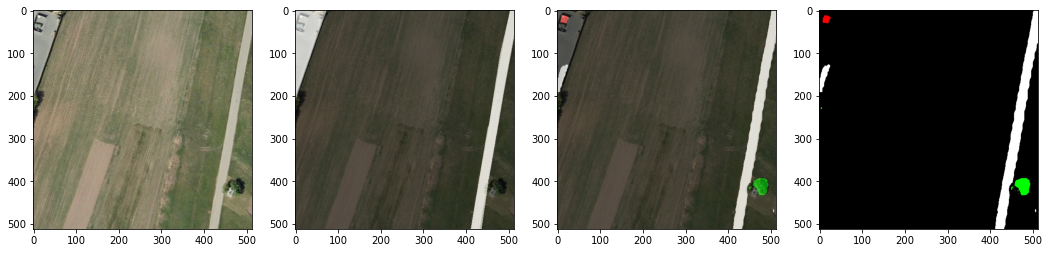

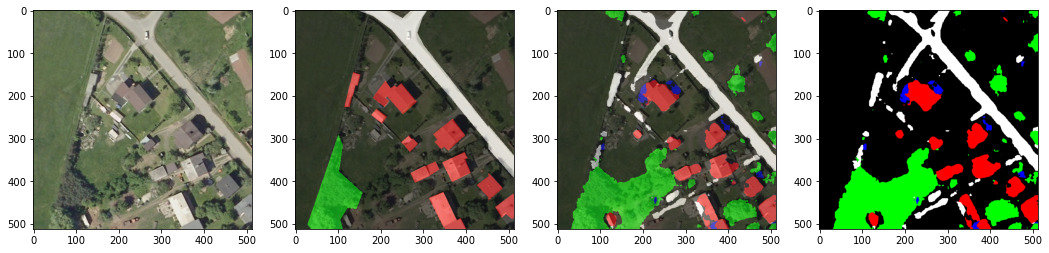

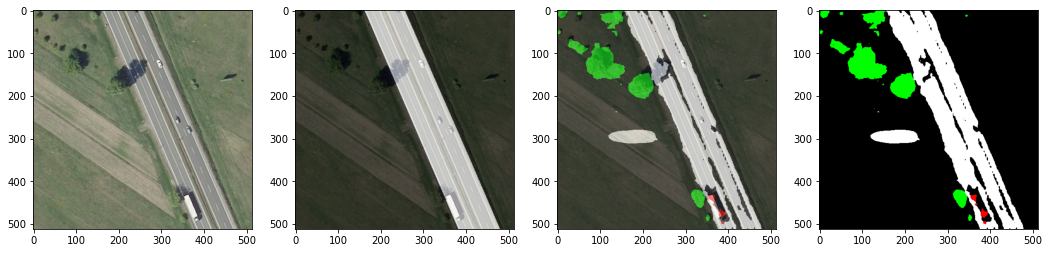

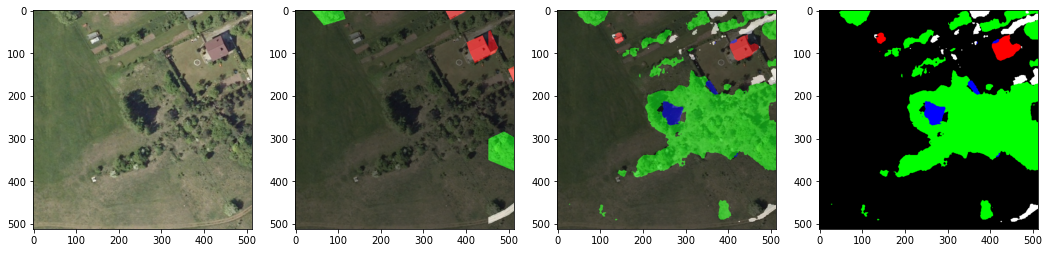

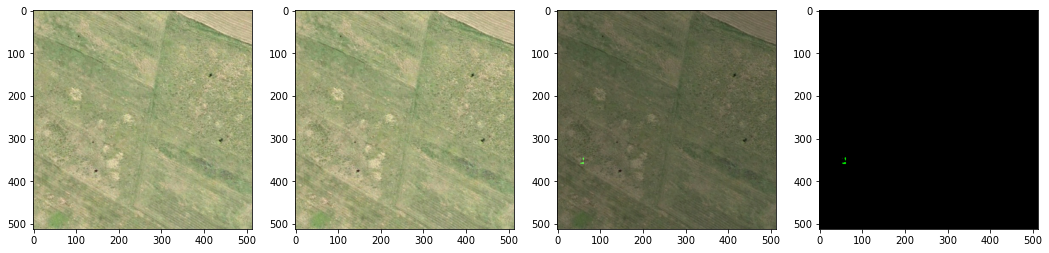

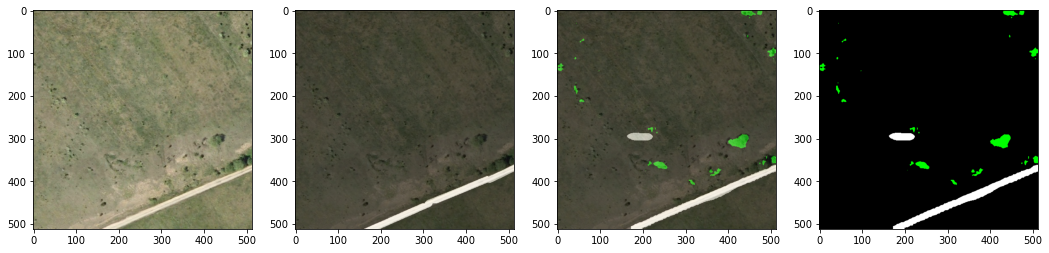

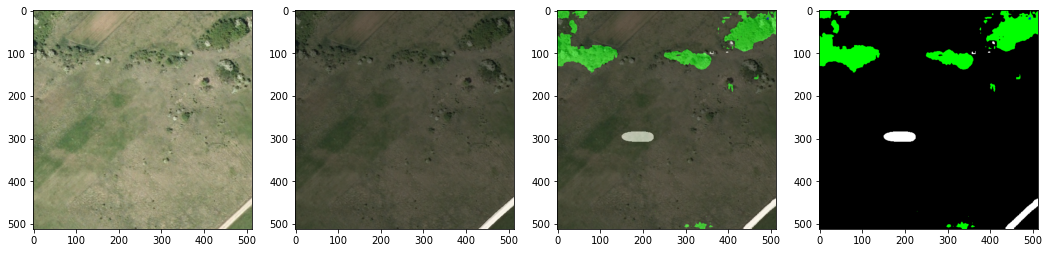

In [103]:
left_range = 448
right_range = 455

plot_predictions(test_images[left_range:right_range],
                 test_masks[left_range:right_range],
                 colormap,
                 model=model)

In [104]:
get_miou_for_images(test_images, test_masks, model)

0.6068467

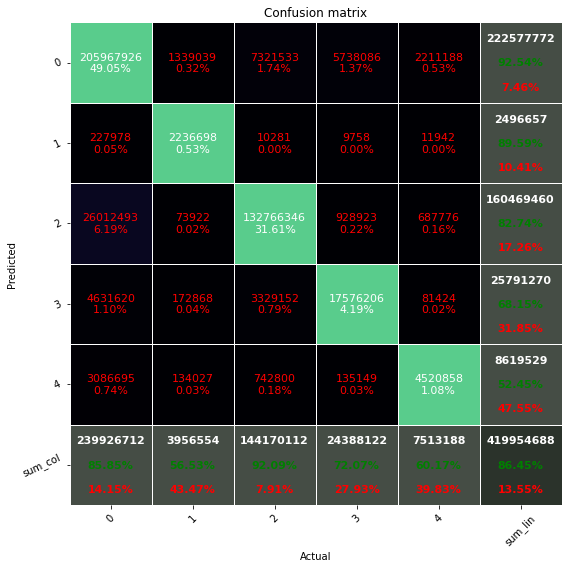

,0,1,2,3,4
0,205967926,227978,26012493,4631620,3086695
1,1339039,2236698,73922,172868,134027
2,7321533,10281,132766346,3329152,742800
3,5738086,9758,928923,17576206,135149
4,2211188,11942,687776,81424,4520858


In [105]:
get_and_display_confusion_matrix(model, NUM_CLASSES)

### Decrease learning rate

In [112]:
del model

In [113]:
model = get_deeplab_model(weights='pascal_voc', freeze_conv_base=False)

In [114]:
# freeze entry and middle flow in modified Xception
for i, layer in enumerate(model.layers):

    if i < 324:
        layer.trainable = False

In [115]:
model.load_weights(path_best_dice_loss_unfrozen)

In [116]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss=soft_dice_loss,
    metrics=["accuracy", custom_mIoU_metric]
)

In [117]:
path_best_dice_loss_unfrozen_p2 = abs_path + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_soft_dice_loss_unfrozen/best_miou_p2/checkpoint'
dir_path_dice_loss_unfrozen_p2 = abs_path + f'/notebooks/exploratory/results/DeepLabv3+/{VERSION}_soft_dice_loss_unfrozen/best_miou_p2'

for path in [dir_path_dice_loss_unfrozen_p2]:
    if not os.path.exists(path):
        os.makedirs(path)

In [118]:
best_miou_dice_loss_p2 = tf.keras.callbacks.ModelCheckpoint(
    path_best_dice_loss_unfrozen_p2,
    monitor='val_mIoU',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)

In [119]:
history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=30,
                    callbacks=[early_stopping_val_mIoU,
                              best_miou_dice_loss]
                   )

Epoch 1/30
3735/3735 [==============================] - 745s 198ms/step - loss: 0.6219 - accuracy: 0.9009 - mIoU: 0.6591 - val_loss: 0.6893 - val_accuracy: 0.8527 - val_mIoU: 0.5755

Epoch 00001: val_mIoU did not improve from 0.60803
Epoch 2/30
3735/3735 [==============================] - 744s 199ms/step - loss: 0.6148 - accuracy: 0.9118 - mIoU: 0.6790 - val_loss: 0.6837 - val_accuracy: 0.8505 - val_mIoU: 0.5971

Epoch 00002: val_mIoU did not improve from 0.60803
Epoch 3/30
3735/3735 [==============================] - 738s 198ms/step - loss: 0.6097 - accuracy: 0.9179 - mIoU: 0.6943 - val_loss: 0.6798 - val_accuracy: 0.8656 - val_mIoU: 0.5942

Epoch 00003: val_mIoU did not improve from 0.60803
Epoch 4/30
3735/3735 [==============================] - 712s 191ms/step - loss: 0.6026 - accuracy: 0.9268 - mIoU: 0.7173 - val_loss: 0.7113 - val_accuracy: 0.8423 - val_mIoU: 0.5182

Epoch 00004: val_mIoU did not improve from 0.60803
Epoch 5/30
  89/3735 [..............................] - ETA: 10:

KeyboardInterrupt: 